In [9]:
from __future__ import annotations

import json
import pickle

import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import uproot3
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from hist import Hist

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41805")
client

Client Scheduler: tcp://127.0.0.1:41805 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 12.88 GB


In [14]:
class JetHTTriggerEfficienciesProcessor(processor.ProcessorABC):
    """Accumulates two 2D (pT, msd) histograms from all input events: 1) before triggers, and 2) after triggers"""

    def __init__(self, ak15=False):
        super(JetHTTriggerEfficienciesProcessor, self).__init__()

        self.muon_HLTs = {
            2016: ["IsoMu24", "IsoTkMu24", "Mu50"],
            2017: ["IsoMu27", "Mu50"],
            2018: ["IsoMu24", "Mu50"],
        }

        self.HLTs = {
            2016: [
                "AK8DiPFJet250_200_TrimMass30_BTagCSV_p20",
                "AK8DiPFJet280_200_TrimMass30_BTagCSV_p20",
                #
                "AK8PFHT600_TrimR0p1PT0p03Mass50_BTagCSV_p20",
                "AK8PFHT700_TrimR0p1PT0p03Mass50",
                #
                "AK8PFJet360_TrimMass30",
                "AK8PFJet450",
                "PFJet450",
                #
                "PFHT800",
                "PFHT900",
                "PFHT1050",
                #
                "PFHT750_4JetPt50",
                "PFHT750_4JetPt70",
                "PFHT800_4JetPt50",
            ],
            2017: [
                "PFJet450",
                "PFJet500",
                #
                "AK8PFJet400",
                "AK8PFJet450",
                "AK8PFJet500",
                #
                "AK8PFJet360_TrimMass30",
                "AK8PFJet380_TrimMass30",
                "AK8PFJet400_TrimMass30",
                #
                "AK8PFHT750_TrimMass50",
                "AK8PFHT800_TrimMass50",
                #
                "PFHT1050",
                #
                "AK8PFJet330_PFAK8BTagCSV_p17",
            ],
            2018: [
                "PFJet500",
                #
                "AK8PFJet500",
                #
                "AK8PFJet360_TrimMass30",
                "AK8PFJet380_TrimMass30",
                "AK8PFJet400_TrimMass30",
                "AK8PFHT750_TrimMass50",
                "AK8PFHT800_TrimMass50",
                #
                "PFHT1050",
                #
                "HLT_AK8PFJet330_TrimMass30_PFAK8BTagCSV_p17_v",
            ],
        }

        # step, min, max
        self.pt_bins = (50, 0, 1000)
        self.msd_bins = (15, 0, 300)

        # edges
        self.tagger_bins = [0.0, 0.9, 0.95, 0.98, 1.0]

        self.ak15 = ak15

    def process(self, events):
        """Returns pre- (den) and post- (num) trigger 2D (pT, msd) histograms from input NanoAOD events"""

        year = int(events.metadata["dataset"][:4])

        # passing single-muon triggers
        muon_triggered = np.any(
            np.array([events.HLT[trigger] for trigger in self.muon_HLTs[year]]),
            axis=0,
        )

        # passing our triggers
        bbVV_triggered = np.any(
            np.array(
                [events.HLT[trigger] for trigger in self.HLTs[year] if trigger in events.HLT.fields]
            ),
            axis=0,
        )

        fatjets = events.FatJetAK15 if self.ak15 else events.FatJet

        # TODO: AK15 jets have different names!
        fatjets.txbb = fatjets.particleNetMD_Xbb / (
            fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb
        )

        # does event have a fat jet
        fatjet1bool = ak.any(fatjets.pt, axis=1)

        # initialize histograms
        h = (
            Hist.new.Var(self.tagger_bins, name="jet1txbb", label="$T_{Xbb}$ Score")
            .Var(self.tagger_bins, name="jet1th4q", label="$T_{H4q}$ Score")
            .Reg(*self.pt_bins, name="jet1pt", label="$p_T$ (GeV)")
            .Reg(*self.msd_bins, name="jet1msd", label="$m_{SD}$ (GeV)")
            .Double()
        )

        selections = {
            # select events which pass the muon triggers and contain at least one fat jet
            "den": fatjet1bool * muon_triggered,
            # add our triggers
            "num": fatjet1bool * muon_triggered * bbVV_triggered,
        }

        hists = {}

        for key, selection in selections.items():
            hists[key] = h.copy().fill(
                jet1txbb=fatjets.txbb[selection][:, 0].to_numpy(),
                jet1th4q=fatjets.particleNet_H4qvsQCD[selection][:, 0].to_numpy(),
                jet1pt=fatjets.pt[selection][:, 0].to_numpy(),
                jet1msd=fatjets.msoftdrop[selection][:, 0].to_numpy(),
            )

        return hists

    def postprocess(self, accumulator):
        return accumulator

In [5]:
def get_fileset(processor: str, year: int, samples: list, subsamples: list, starti: int, endi: int):
    if processor == "trigger":
        index_file = f"../data/singlemuon_pfnanoindex_{year}.json"
        samples = [f"SingleMu{year}"]
    else:
        index_file = f"../data/pfnanoindex_{year}.json"

    with open(index_file) as f:
        full_fileset = json.load(f)

    fileset = {}

    for sample in samples:
        sample_set = full_fileset[year][sample]
        set_subsamples = list(sample_set.keys())

        # check if any subsamples for this sample have been specified
        get_subsamples = set(set_subsamples).intersection(subsamples)

        # if so keep only that subset
        if len(get_subsamples):
            sample_set = {subsample: sample_set[subsample] for subsample in get_subsamples}

        sample_fileset = {}

        for subsample, fnames in sample_set.items():
            fnames = fnames[starti:] if endi < 0 else fnames[starti:endi]
            sample_fileset[f"{year}_{subsample}"] = [
                "root://cmsxrootd.fnal.gov//" + fname for fname in fnames
            ]

        fileset = {**fileset, **sample_fileset}

    return fileset

In [6]:
fileset = get_fileset("trigger", "2017", [], [], 0, -1)

In [7]:
small_fileset = {"2017_SingleMuon_Run2017B": fileset["2017_SingleMuon_Run2017B"][:1]}

In [16]:
import time

tic = time.time()

# for LPC

# from lpcjobqueue import LPCCondorCluster
# from distributed import Client
# cluster = LPCCondorCluster()
# # minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
# cluster.adapt(minimum=1, maximum=100)
# client = Client(cluster)

exe_args = {
    "client": client,
    "savemetrics": True,
    "schema": NanoAODSchema,
    # "align_clusters": True,
    # "skipbadfiles": True,
}


print("Waiting for at least one worker...")
client.wait_for_workers(1)

print("Found at least one worker...")

out, metrics = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=JetHTTriggerEfficienciesProcessor(),
    executor=processor.dask_executor,
    executor_args=exe_args,
    #     maxchunks=10
)

elapsed = time.time() - tic

print(f"num: {out['num'].view(flow=True)}")
print(f"den: {out['den'].view(flow=True)}")

print(f"Metrics: {metrics}")
print(f"Finished in {elapsed:.1f}s")

Waiting for at least one worker...
Found at least one worker...


RuntimeError: can't start new thread

In [9]:
out

{'den': Hist(
   Variable([0, 250, 300, 350, 400, 500, 750, 1000]),
   Regular(50, 0, 1000, name='bbjetpt', label='AK8 bb Fat Jet $p_T$ (GeV)'),
   Regular(15, 0, 300, name='bbjetmsd', label='AK8 bb Fat Jet MassSD (GeV)'),
   storage=Double()) # Sum: 10979756.0 (16351283.0 with flow),
 'num': Hist(
   Variable([0, 250, 300, 350, 400, 500, 750, 1000]),
   Regular(50, 0, 1000, name='bbjetpt', label='AK8 bb Fat Jet $p_T$ (GeV)'),
   Regular(15, 0, 300, name='bbjetmsd', label='AK8 bb Fat Jet MassSD (GeV)'),
   storage=Double()) # Sum: 975467.0 (1005485.0 with flow)}

In [ ]:
effs = out["num"] / out["den"]

In [10]:
filehandler = open("out_hybrid.pickle", "wb")
pickle.dump(out, filehandler)
filehandler.close()

In [11]:
effs = out["num"] / out["den"]
effs

Hist(
  Variable([0, 250, 300, 350, 400, 500, 750, 1000]),
  Regular(50, 0, 1000, name='bbjetpt', label='AK8 bb Fat Jet $p_T$ (GeV)'),
  Regular(15, 0, 300, name='bbjetmsd', label='AK8 bb Fat Jet MassSD (GeV)'),
  storage=Double()) # Sum: nan (nan with flow)

In [12]:
filehandler = open("corrections/trigEffs/AK15JetHTHybrid3DTriggerEfficiency_2017.hist", "wb")
pickle.dump(effs, filehandler)
filehandler.close()

In [25]:
ak15_trig_effs = uproot3.recreate("corrections/trigEffs/AK15JetHT3DTriggerEfficiency_2017.root")
ak15_trig_effs["efficiency_ptmass"] = effs.to_numpy(
    flow=True
)  # convert to float (double check if we should be doing this...)
ak15_trig_effs["efficiency_ptmass"]

TypeError: type tuple from module builtins is not writeable by uproot3

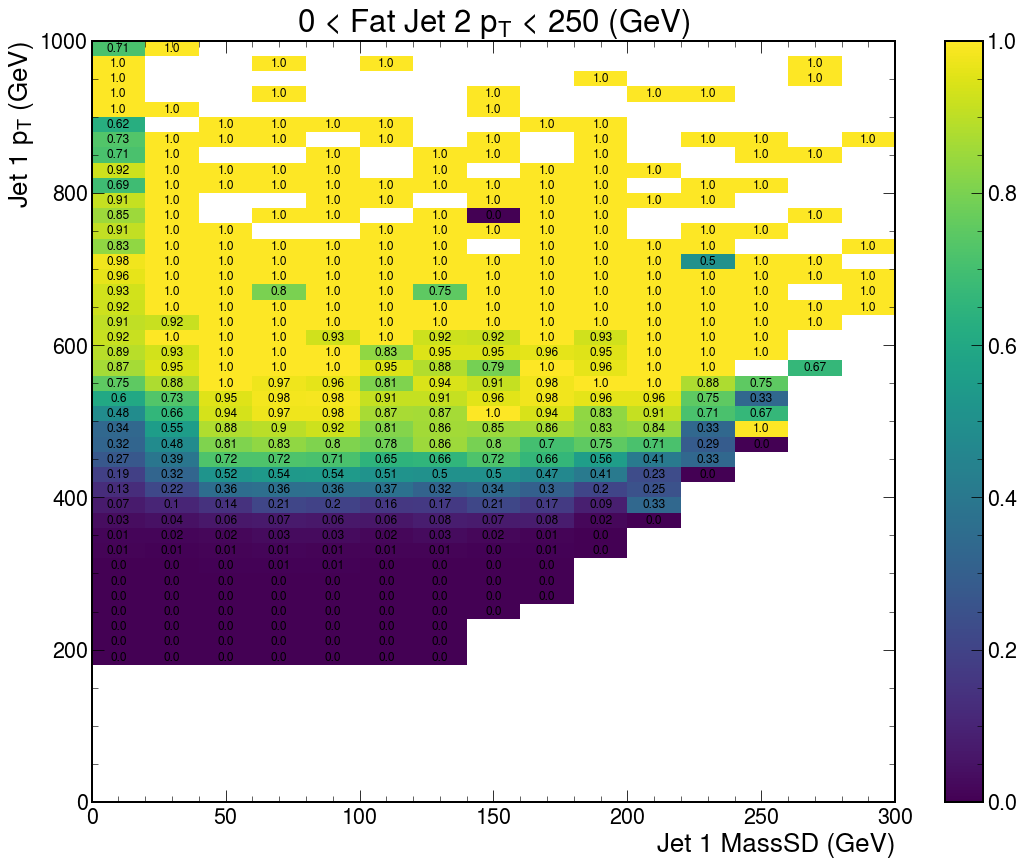

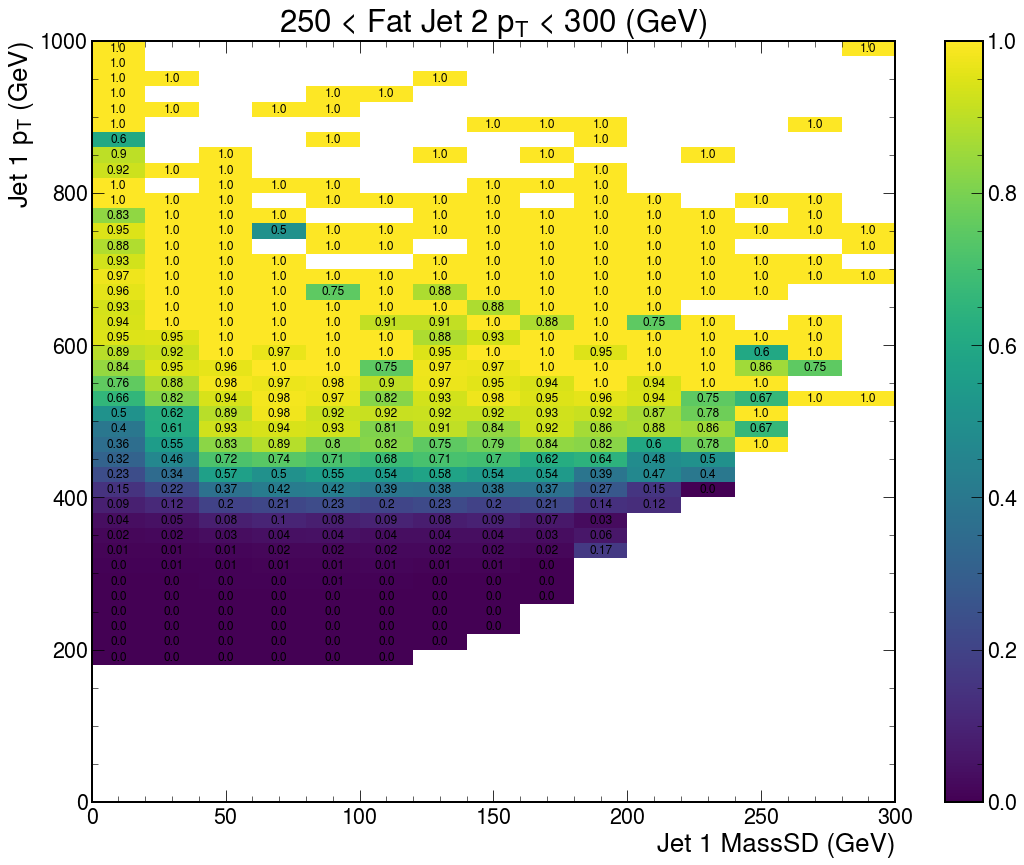

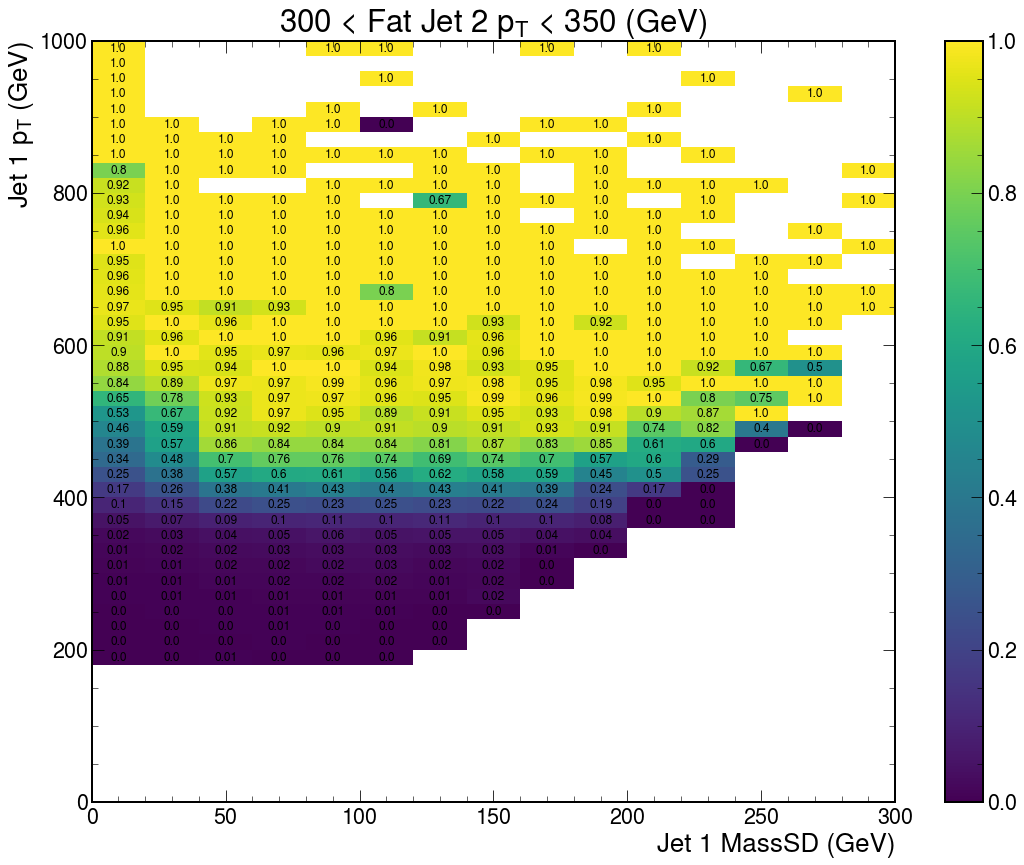

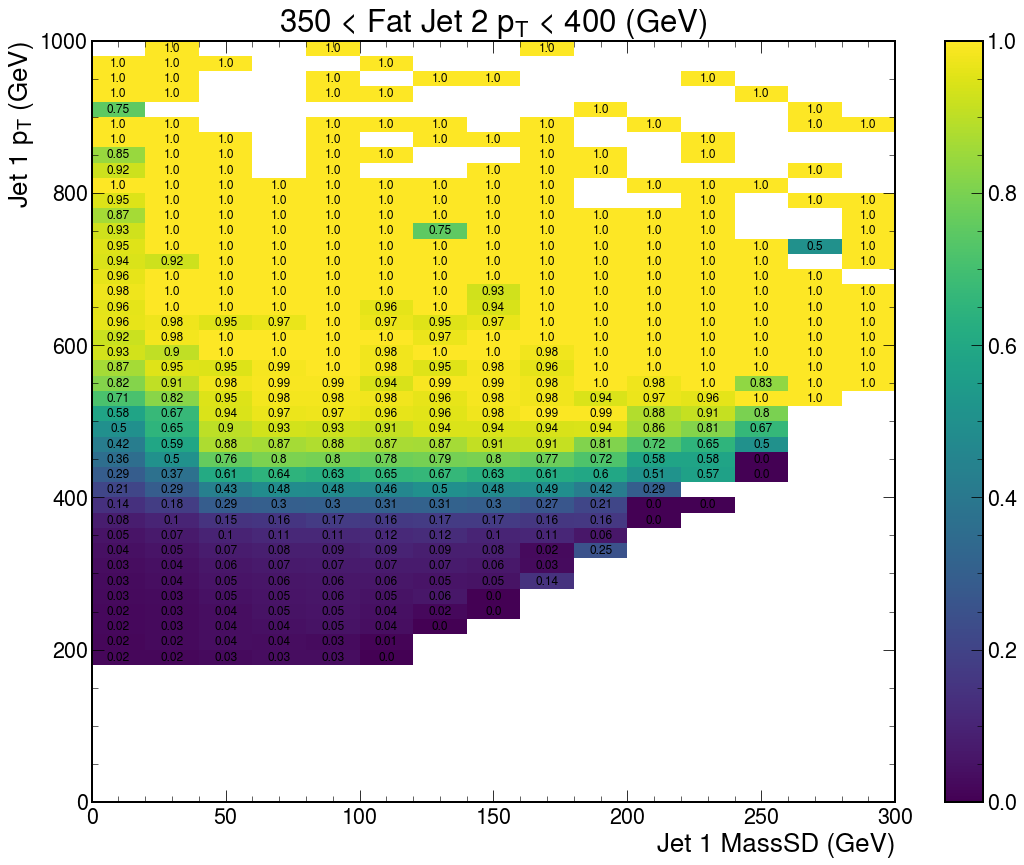

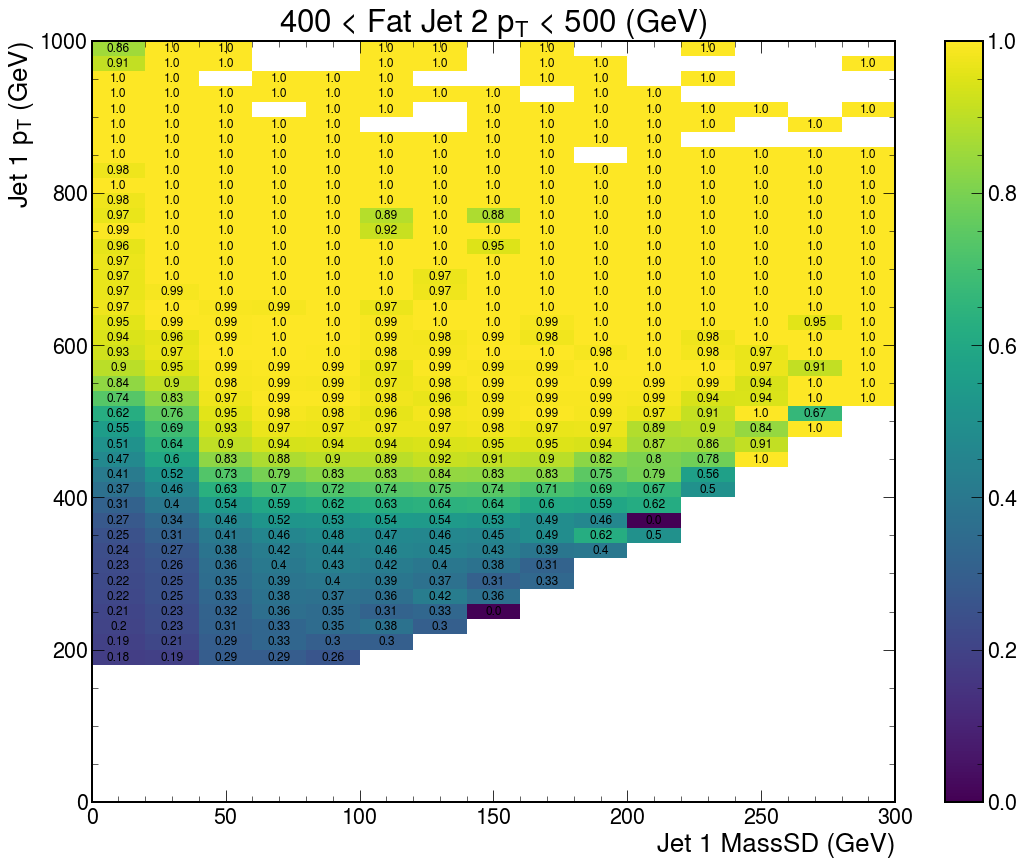

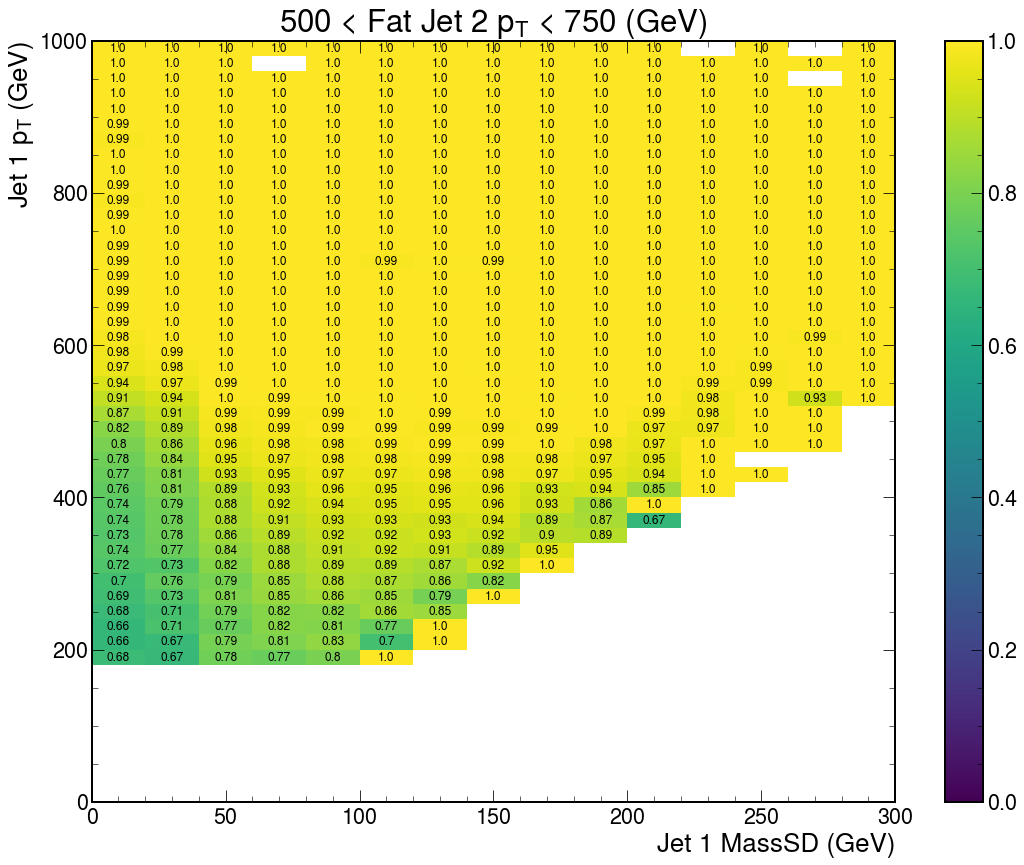

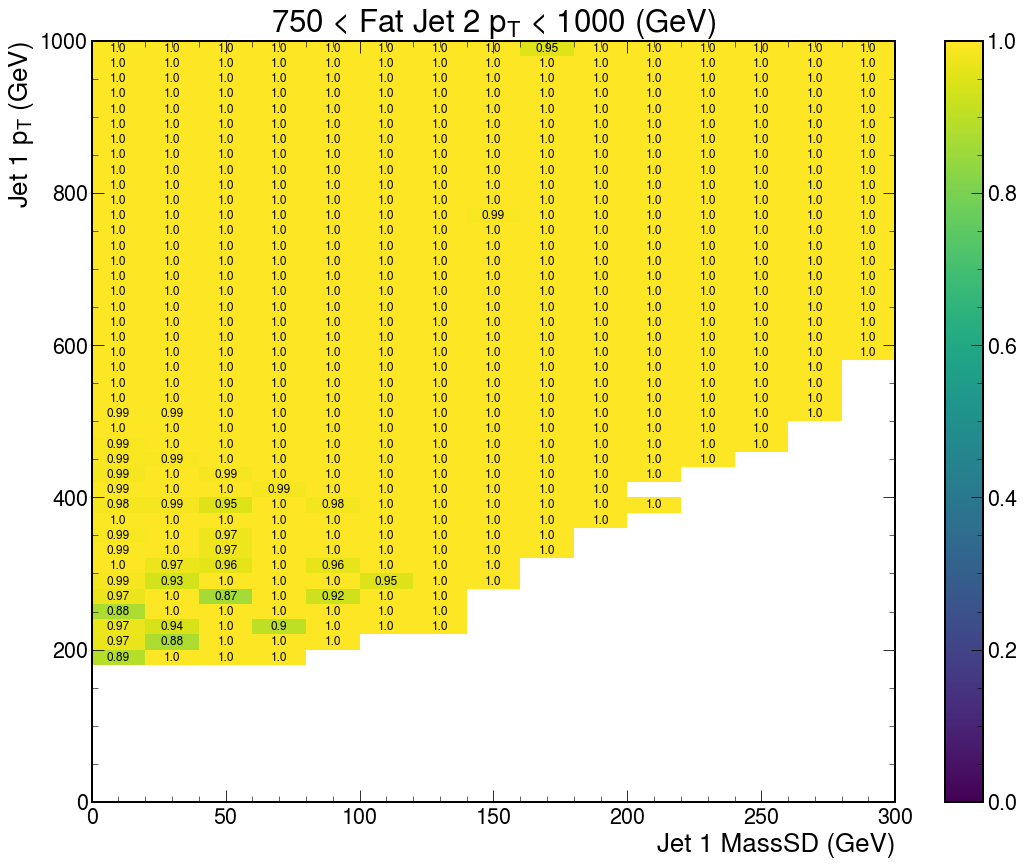

In [15]:
import math

w, jet2ptbins, jet1ptbins, jet1msdbins = effs.to_numpy()


plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)


for k in range(len(jet2ptbins) - 1):
    fig, ax = plt.subplots(figsize=(18, 14))
    mesh = ax.pcolormesh(jet1msdbins, jet1ptbins, w[k], cmap="viridis", vmin=0, vmax=1)
    for i in range(len(jet1ptbins) - 1):
        for j in range(len(jet1msdbins) - 1):
            if not math.isnan(w[k][i, j]):
                ax.text(
                    (jet1msdbins[j] + jet1msdbins[j + 1]) / 2,
                    (jet1ptbins[i] + jet1ptbins[i + 1]) / 2,
                    w[k][i, j].round(2),
                    color="black",
                    ha="center",
                    va="center",
                    fontsize=12,
                )

    ax.set_title(f"{jet2ptbins[k]:.0f} < Fat Jet 2 $p_T$ < {jet2ptbins[k + 1]:.0f} (GeV)")
    ax.set_xlabel("Jet 1 MassSD (GeV)")
    ax.set_ylabel("Jet 1 $p_T$ (GeV)")
    plt.colorbar(mesh, ax=ax)
    plt.savefig(f"corrections/trigEffs/Hybrid3D/AK15Hybrid3DTriggerEfficiencies_Bin{k}.pdf")

In [2]:
import pickle

filehandler = open("out.pickle", "rb")
out = pickle.load(filehandler)
filehandler.close()

In [4]:
out["den"].view() / out["num"].view()

/tmp/ipykernel_116/3670843515.py:1: RuntimeWarning: divide by zero encountered in true_divide
  out['den'].view() / out['num'].view()
/tmp/ipykernel_116/3670843515.py:1: RuntimeWarning: invalid value encountered in true_divide
  out['den'].view() / out['num'].view()


array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [2.25      ,        nan, 1.        , ...,        nan,
         1.        ,        nan],
        [2.16666667,        nan,        nan, ...,        nan,
         1.        , 1.        ],
        [1.45454545, 1.        ,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.05263158, 1.        , 1.        , ...,        nan,
         1.        , 1.        ],
        [1.0

In [6]:
out["den"][0, :, :]

Hist(
  Regular(50, 0, 1000, name='jet1pt', label='AK15 Fat Jet 1 $p_T$ (GeV)'),
  Regular(15, 0, 300, name='jet1msd', label='AK15 Fat Jet 1 MassSD (GeV)'),
  storage=Double()) # Sum: 15685210.0 (28858941.0 with flow)

In [7]:
out["den"][1, :, :]

Hist(
  Regular(50, 0, 1000, name='jet1pt', label='AK15 Fat Jet 1 $p_T$ (GeV)'),
  Regular(15, 0, 300, name='jet1msd', label='AK15 Fat Jet 1 MassSD (GeV)'),
  storage=Double()) # Sum: 4245155.0 (4405966.0 with flow)

In [8]:
out["den"][2, :, :]

Hist(
  Regular(50, 0, 1000, name='jet1pt', label='AK15 Fat Jet 1 $p_T$ (GeV)'),
  Regular(15, 0, 300, name='jet1msd', label='AK15 Fat Jet 1 MassSD (GeV)'),
  storage=Double()) # Sum: 215539.0 (261900.0 with flow)

In [9]:
out["den"][3, :, :]

Hist(
  Regular(50, 0, 1000, name='jet1pt', label='AK15 Fat Jet 1 $p_T$ (GeV)'),
  Regular(15, 0, 300, name='jet1msd', label='AK15 Fat Jet 1 MassSD (GeV)'),
  storage=Double()) # Sum: 19680.0 (33413.0 with flow)